In [180]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [181]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [182]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import datetime, timedelta
import matplotlib.dates as mdates


In [183]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [184]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables



C:\Users\franc\AppData\Local\Temp\ipykernel_49112\1750785878.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [185]:
# View all of the classes that automap found
# View all of the classes that automap found
classes_found = Base.classes.keys()
print(classes_found)

['measurement', 'station']


In [186]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [187]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)


# Exploratory Precipitation Analysis

In [188]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


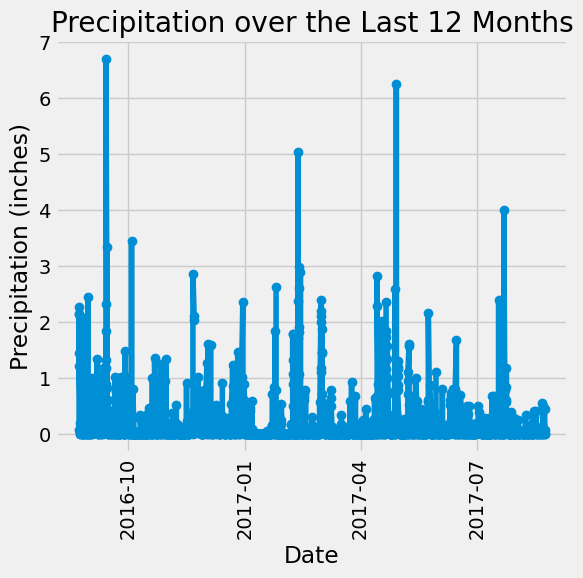

In [189]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date

# Convert the most recent date to a datetime object
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Ensure that the 'date' column is in datetime format
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])
# Sort the dataframe by date
precipitation_df.sort_values(by='date', inplace=True)  # Not needed as we ordered in the query

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(6, 6))
plt.plot(precipitation_df['date'], precipitation_df['precipitation'], marker='o', linestyle='-')
plt.title('Precipitation over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
# Set x-axis major locator to display every 3 months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [199]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Calculate summary statistics for the precipitation data
summary_statistics = precipitation_df['precipitation'].describe()

# Convert the summary statistics to a DataFrame
summary_df = summary_statistics.to_frame().reset_index()

# Rename the columns for better clarity
summary_df.columns = ['Statistic', 'Value']

# Print the summary DataFrame
summary_df

,Statistic,Value
0,count,2015.000000
1,mean,0.176462
2,std,0.460288
3,min,0.000000
4,25%,0.000000
5,50%,0.020000
6,75%,0.130000
7,max,6.700000


# Exploratory Station Analysis

In [200]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

# Print the total number of stations
print(f'Total number of stations: {total_stations}')

Total number of stations: 9


In [202]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(
    Station.station, func.count(Measurement.station).label('count')
).join(Measurement, Station.station == Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Print the results
for station, count in active_stations:
    print(f'Station ID: {station}, Active: {count}')

Station ID: USC00519281, Active: 2772
Station ID: USC00519397, Active: 2724
Station ID: USC00513117, Active: 2709
Station ID: USC00519523, Active: 2669
Station ID: USC00516128, Active: 2612
Station ID: USC00514830, Active: 2202
Station ID: USC00511918, Active: 1979
Station ID: USC00517948, Active: 1372
Station ID: USC00518838, Active: 511


In [203]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0][0]  # Get the station ID from the previous query

# Query to calculate the lowest, highest, and average temperatures for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station_id).all()

# Print the results
min_temp, max_temp, avg_temp = temperature_stats[0]
print(f'For station {most_active_station_id}:')
print(f'Lowest Temperature: {min_temp}')
print(f'Highest Temperature: {max_temp}')
print(f'Average Temperature: {avg_temp}')

For station USC00519281:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


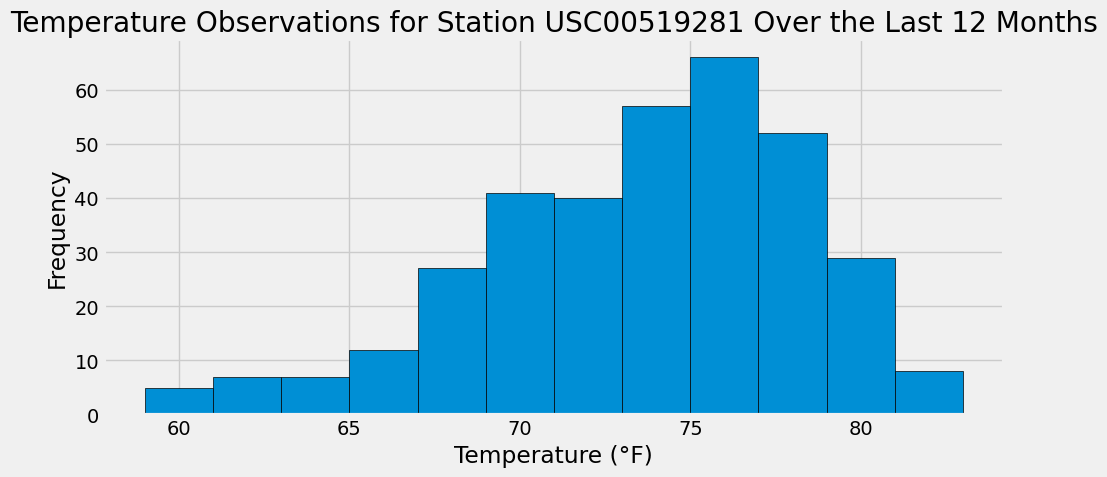

In [204]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Calculate the date one year from the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)

# Query to get the last 12 months of temperature observation data for the most active station
last_12_months_tobs = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

# Convert the results to a list
tobs_list = [tobs[0] for tobs in last_12_months_tobs]

# Plot the results as a histogram
plt.figure(figsize=(10, 5))
plt.hist(tobs_list, bins=12, edgecolor='black')
plt.title(f'Temperature Observations for Station {most_active_station_id} Over the Last 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [195]:
# Close Session
session.close()